In [55]:
import pandas as pd
import unidecode
import re

In [98]:
def clean_col_names(df_):

    df = df_.copy()
    cols = df.columns.to_list()
    new_cols=[]
    for col in cols:
        
        col = re.sub(' +', ' ', col)
        col = col.replace(' ','_')
        col = col.replace('/','')
        col = col.replace('$','dollar')
        col = col.upper()
        new_cols.append(col)

    df.columns = new_cols

    return df
    
def stdr_names(series_original):
    '''Clean company names. To be used in the different files so names are likelier to be matched'''
    series = series_original.copy()
    series = series.astype(str)
    
    series = series.str.upper()
    series = series.str.strip()

    series = series.replace(r'\s+', ' ', regex=True)
    series = series.str.replace(r'[^\w\s]+', '', regex=True)


    series = series.apply(lambda x: unidecode.unidecode(x))

    series = series.str.replace(' QUEBEC ', '')
    series = series.str.replace('CANADA', '')
    series = series.str.replace(' MONTREAL ', '')
    series = series.str.replace('MONTREAL ', '')
    series = series.str.replace(' MONTREAL', '')
    series = series.str.replace(' INC', '')
    series = series.str.replace(' INC ', '')
    series = series.str.replace(' CIE ', '')
    series = series.str.replace(' CIE', '')
    series = series.str.replace(' LTEE', '')
    series = series.str.replace('CORPORATION', '')
    series = series.str.replace('INTERNATIONAL', '')
    return series

In [99]:
df_donors = pd.read_csv('../Data/past_donors_clean.csv', parse_dates=[1])
df_orgs = pd.read_excel('../Data/Organizations_stg.xlsx')

df_donors=clean_col_names(df_donors)
df_orgs=clean_col_names(df_orgs)

# now we read the matches after reviews them and this will become our key to match both sources
df_matches = pd.read_excel('../Data/matched_orgs_k4kreview.xlsx')

df_donors.COMPANY = stdr_names(df_donors.COMPANY)
df_orgs.NAME = stdr_names(df_orgs.NAME)

In [100]:
df_orgs = df_orgs.drop(columns = ['ISFOUNDATION'])

df_fonds = pd.read_excel('../Data/Foundations_stg.xlsx')
df_fonds = clean_col_names(df_fonds)
df_fonds['ISFOUNDATION'] = 1

df_orgs = df_orgs.merge(df_fonds[['ID', 'ISFOUNDATION']], how='left', on='ID')
df_orgs.ISFOUNDATION.fillna(0, inplace=True)

## add foundations dataset attributes

In [101]:
df_matches = df_matches[df_matches.Match == 1] # keeping only matches
df_matches = df_matches.iloc[:, 0:2]
df_matches.columns = ['ORGANIZATION', 'DONOR']

In [102]:
# some past donors have been matched with more than 1 different company in the PDF source, so we need to select and keep only one so the analysis is consistent.
donor_q = df_matches.DONOR.value_counts()
organization_q = df_matches.ORGANIZATION.value_counts()
df1 = df_matches[df_matches.DONOR.isin(donor_q[donor_q > 1].index)].sort_values('DONOR').reset_index(drop=True)

In [103]:

ixs = [1, 2,5,6,10,11,15,16,18, 21,22] 
df1 = df1.iloc[ixs,:].reset_index(drop=True)

In [104]:
# now we concatenate the matches into a single df
df_matches = pd.concat([ df_matches[df_matches.DONOR.isin(donor_q[donor_q <= 1].index)].sort_values('DONOR').reset_index(drop=True),
            df1 ] )

In [105]:
df_donors_match = df_donors.merge(df_matches, how = 'inner', left_on = 'COMPANY', right_on = 'DONOR')

In [106]:
df_donors_match.ORGANIZATION.nunique()

55

In [107]:
df_donors_match = df_donors_match[['ORGANIZATION']].drop_duplicates()

In [108]:
df_donors_match2 = df_donors_match.merge(df_orgs, how = 'right', left_on = 'ORGANIZATION', right_on = 'NAME')

# after matching, flag the ones in past donors

In [109]:
df = df_donors_match2.drop_duplicates().reset_index(drop=True)


In [110]:
df['FLG_PAST_DONOR'] = df.ORGANIZATION.notna().astype(int)

In [111]:
df.columns

Index(['ORGANIZATION', 'ID', '2E_CONTACT_POUR', 'ADDRESS', 'AVIS', 'CONTACT',
       'CONTRIBUTION', 'COURRIEL', 'DDD', 'DOMAINE_DINTERET', 'FAF', 'FAX',
       'FILIALE_DE', 'LANGUE', 'LIMITES_GEOG', 'N_DE_TEL', 'NAME',
       'NBRE_DE_SUCC', 'NOMBRE_DEMPLOYES', 'NOTE', 'POSTE', 'PRINCIP_FILIALES',
       'SECTEUR_INDUSTRIEL', 'SITE_WEB', 'MUNICIPALITY', 'PROVINCE',
       'POSTALCODE', 'STREET', 'SECTOR_FABRICATION', 'SECTOR_FINANCIERS',
       'SECTOR_COMMERCE', 'SECTOR_CONSTRUCTION', 'SECTOR_TRANSPORT',
       'SECTOR_GESTION', 'SECTOR_SYSTEMS', 'SECTOR_ALIMENTATION',
       'SECTOR_SANTE_ASSURANCE', 'SECTOR_OTHER', 'GENERAL_CHARITY',
       'HEALTH_ARTS_CULTURE', 'COMMUNITY_ENVIRONMENTAL',
       'YOUTH_HEALTH_EDUCATION', 'REGIONAL_SPECIFIC',
       'CANCER_DISEASE_RESEARCH', 'INTEREST_DOMAIN_CLEAN', 'MAIN_TOPIC',
       'MAIN_TOPIC_SCORE', 'SECONDARY_TOPIC', 'SECONDARY_TOPIC_SCR',
       'ISFOUNDATION', 'FLG_PAST_DONOR'],
      dtype='object')

In [112]:
df = df[ ['NAME',
'FLG_PAST_DONOR',
       'FILIALE_DE', 
       'ISFOUNDATION', 
        'LIMITES_GEOG',
         'NOMBRE_DEMPLOYES',
       'PRINCIP_FILIALES', 
       'SECTOR_FABRICATION', 'SECTOR_FINANCIERS', 'SECTOR_COMMERCE',
       'SECTOR_CONSTRUCTION', 'SECTOR_TRANSPORT', 'SECTOR_GESTION',
       'SECTOR_SYSTEMS', 'SECTOR_ALIMENTATION', 'SECTOR_SANTE_ASSURANCE',
       'SECTOR_OTHER', 'GENERAL_CHARITY',
       'HEALTH_ARTS_CULTURE', 'COMMUNITY_ENVIRONMENTAL',
       'YOUTH_HEALTH_EDUCATION', 'REGIONAL_SPECIFIC',
       'CANCER_DISEASE_RESEARCH'         
         ]]

In [113]:
df['FILIALE_FLG'] = df.FILIALE_DE.isna().astype(int)


In [114]:
df.LIMITES_GEOG = df.LIMITES_GEOG.str.strip('.').astype(str)

mapper = { 'locales, régionales et nationales' :'regional and national',
'locales' : 'locals',
'nationales' : 'nationals',
'régionales' :'regionals',
'nationales, régionales au Québec' : 'regional and national',
'régionales et nationales' : 'regional and national',
'locales, régionales':'local and regional',
'locales et régionales':'local and regional',
'locales, nationales et internationales':'international',
'nan':'nan',
'nationales et internationales':'international'}

df.LIMITES_GEOG = df.LIMITES_GEOG.map(mapper)

In [115]:
df['FILIALE_FLG2'] = df.PRINCIP_FILIALES.isna().astype(int)



In [116]:
df.NOMBRE_DEMPLOYES = df.NOMBRE_DEMPLOYES.astype(str).str.replace(' ','').astype(float)


In [117]:
df = df.drop(columns = ['PRINCIP_FILIALES', 'FILIALE_DE' ])

In [118]:
df.ISFOUNDATION.value_counts()

0.0    1264
1.0      78
Name: ISFOUNDATION, dtype: int64

In [119]:
df.head().T

,0,1,2,3,4
NAME,3M,A D PREVOST,AAR AICRAFT SERVICES TROISRIVIERES,ABB ALBERT BOB BOB,ABB
FLG_PAST_DONOR,0,0,0,0,0
ISFOUNDATION,0.0,0.0,0.0,0.0,0.0
LIMITES_GEOG,regionals,locals,nationals,locals,regionals
NOMBRE_DEMPLOYES,100.0,200.0,340.0,160.0,1400.0
SECTOR_FABRICATION,1,1,0,1,1
SECTOR_FINANCIERS,0,0,0,0,0
SECTOR_COMMERCE,0,0,0,0,1
SECTOR_CONSTRUCTION,0,1,1,0,0
SECTOR_TRANSPORT,0,0,0,0,1


In [120]:
cols_to_encode = ['LIMITES_GEOG']
dummies = pd.get_dummies(df[cols_to_encode])

df = pd.concat( [df, dummies], axis = 1).drop(columns = cols_to_encode)

In [121]:
from sklearn.preprocessing import StandardScaler

df.NOMBRE_DEMPLOYES.fillna(0, inplace=True)

scaler = StandardScaler()
df.NOMBRE_DEMPLOYES = scaler.fit_transform(df[['NOMBRE_DEMPLOYES']])

In [122]:
df.head().T

,0,1,2,3,4
NAME,3M,A D PREVOST,AAR AICRAFT SERVICES TROISRIVIERES,ABB ALBERT BOB BOB,ABB
FLG_PAST_DONOR,0,0,0,0,0
ISFOUNDATION,0.0,0.0,0.0,0.0,0.0
NOMBRE_DEMPLOYES,-0.224658,-0.193808,-0.150618,-0.206148,0.176397
SECTOR_FABRICATION,1,1,0,1,1
SECTOR_FINANCIERS,0,0,0,0,0
SECTOR_COMMERCE,0,0,0,0,1
SECTOR_CONSTRUCTION,0,1,1,0,0
SECTOR_TRANSPORT,0,0,0,0,1
SECTOR_GESTION,0,0,0,0,0


In [123]:
df_x = df.iloc[:,2:]

In [124]:
y = df['FLG_PAST_DONOR'].to_numpy()

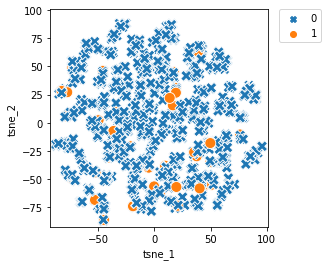

In [125]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
 
# We want to get TSNE embedding with 2 dimensions
n_components = 2
tsne = TSNE(n_components, perplexity = 5)
tsne_result = tsne.fit_transform(df_x)
tsne_result.shape
# (1000, 2)
# Two dimensions for each of our images

 # Plot the result of our TSNE with the label color coded
# A lot of the stuff here is about making the plot look pretty and not TSNE
tsne_result_df = pd.DataFrame({'tsne_1': tsne_result[:,0], 'tsne_2': tsne_result[:,1], 'label': y})
fig, ax = plt.subplots(1)
sns.scatterplot(x='tsne_1', y='tsne_2', hue='label', style = 'label', style_order = [1,0], data=tsne_result_df, ax=ax,s=120)
lim = (tsne_result.min()-5, tsne_result.max()+5)
ax.set_xlim(lim)
ax.set_ylim(lim)
ax.set_aspect('equal')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

plt.show()

In [126]:
df_x = df.loc[df.FLG_PAST_DONOR == 0].reset_index(drop=True)

df_y = df.loc[df.FLG_PAST_DONOR == 1].reset_index(drop=True)

In [127]:
from scipy import spatial
import warnings
warnings.filterwarnings('ignore')

df_scores_acum  = pd.DataFrame( columns = ['org', 'past_donor','score'])
for _, r in df_x.iterrows():

    scores = []

    org = r[0]
    vec_x = r.to_list()[2:]

    for _, r2 in df_y.iterrows():
        past_donor = r2[0]
        vec_y = r2.to_list()[2:]

        similarity =  1 - spatial.distance.cosine(vec_x, vec_y)
        scores.append( [org, past_donor , similarity] )

    df_scores = pd.DataFrame(data = scores, columns = ['org', 'past_donor', 'score']).nlargest(4, columns ='score')
    df_scores = df_scores.append({'org':org, 'past_donor':'4_CLOSEST_AVERAGE', 'score': df_scores.score.mean()}, ignore_index=True)

    df_scores_acum = pd.concat([df_scores_acum, df_scores])
    
df_scores_acum= df_scores_acum.reset_index(drop=True)

    


In [128]:
df_scores_acum[df_scores_acum.past_donor == '4_CLOSEST_AVERAGE'].sort_values('score', ascending=False).head(20)

,org,past_donor,score
2844,HARNOIS ENERGIES,4_CLOSEST_AVERAGE,0.885992
5724,STRUCTURES UTRATEC,4_CLOSEST_AVERAGE,0.885031
2604,GHD,4_CLOSEST_AVERAGE,0.884452
2934,HOTEL BONAVENTURE,4_CLOSEST_AVERAGE,0.875718
6029,TRANSPORT BOURRET,4_CLOSEST_AVERAGE,0.875502
5339,SCHENKER DU,4_CLOSEST_AVERAGE,0.87333
129,AGRIMARCHE,4_CLOSEST_AVERAGE,0.872494
4399,OCEANEX,4_CLOSEST_AVERAGE,0.870089
4309,NOLITOURS,4_CLOSEST_AVERAGE,0.869361
3854,MAPLE LEAFS MILLS,4_CLOSEST_AVERAGE,0.865274


In [129]:
df_scores_acum[df_scores_acum.past_donor == '4_CLOSEST_AVERAGE'].sort_values('score', ascending=False).head(10).org

2844      HARNOIS ENERGIES
5724    STRUCTURES UTRATEC
2604                   GHD
2934     HOTEL BONAVENTURE
6029     TRANSPORT BOURRET
5339          SCHENKER DU 
129             AGRIMARCHE
4399               OCEANEX
4309             NOLITOURS
3854     MAPLE LEAFS MILLS
Name: org, dtype: object

In [147]:
df_scores_acum[df_scores_acum.org == 'AGRIMARCHE']

,org,past_donor,score
125,AGRIMARCHE,SLEEMAN UNIBROUE QUEBEC,0.98262
126,AGRIMARCHE,LABATT,0.892503
127,AGRIMARCHE,ALIMENTS MAPLE LEAF,0.833044
128,AGRIMARCHE,LASSONDE,0.781809
129,AGRIMARCHE,4_CLOSEST_AVERAGE,0.872494


In [345]:
df_scores_acum

,org,past_donor,score
0,ZURICH AMERIQUE DU NORD,DESJARDINS CAISSE CENTRALE,0.538538
1,ZURICH AMERIQUE DU NORD,SOLUTIONS KSH,0.466913
2,ZURICH AMERIQUE DU NORD,GUAY,0.464343
3,3M,3_CLOSEST_AVERAGE,0.489931
